# "Energy Storage using the Powell Unified Framework (Part 1)"

> Using Sequential Decision Analytics to find ongoing optimal decisions
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/EnergyStorage1.png
- categories: [Energy_Storage,   Powell_Unified_Framework,   RL]
- show_tags: true

In [121]:
# hide
# based on EnergyStorage_I_ANNO-2.ipynb

#use 1-hot for the PFA policy

## 0 STRUCTURE & FRAMEWORK

The overall *structure* of this project and report follows the traditional CRISP-DM format. However, instead of the CRISP-DM'S "4 Modeling" section, we inserted the "6 step modeling process" of Dr. Warren in section 4 of this document.

The example explored (but also modified) in this report comes from [Dr. Warren Powell](https://castlelab.princeton.edu/people/) (formerly at Princeton). It was chosen as a template to create a POC for a client. It was important to understand this example thoroughly before embarking on creating the POC. Dr Powell's unified framework shows great promise for unifying the formalisms of at least a dozen different fields. Using his framework enables easier access to thinking patterns in these other fields that might be beneficial and informative to the sequential decision problem at hand. Traditionally, this kind of problem would be approached from the *reinforcement learning* perspective. However, using Dr. Powell's wider and more comprehensive perspective almost certainly provides additional value.

Here is information on Dr. Powell's perspective on [Sequential Decision Analytics](https://castlelab.princeton.edu/sda).

The original code for this example can be found [here](https://github.com/wbpowell328/stochastic-optimization/tree/master/EnergyStorage_I).

In order to make a strong mapping between the code in this notebook and the mathematics in the unified framework, many variable names in the original code have been adapted. Here is a summary of the mapping between the mathematics and the variable names in the code:

- Superscripts
  - variable names have a *double* underscore to indicate a superscript
  - $X^{\pi}$: has code `X__pi`, is read *X pi*
- Subscripts
  - variable names have a *single* underscore to indicate a subscript
  - $S_t$: has code `S_t`, is read 'S at t'
  - $M^{Spend}_t$ has code `M__Spend_t` which is read: "MSpend at t"
- Arguments
  - collection variable names may have argument information added
  - $X^{\pi}(S_t)$: has code `X__piIS_tI`, is read 'X pi in S at t'
  - the surrounding `I`'s are used to imitate the parentheses around the argument
- Next time/iteration
  - variable names that indicate one step in the future are quite common
  - $R_{t+1}$: has code `R_tt1`, is read 'R at t+1'
  - $R^{n+1}$: has code `R__nt1`, is read 'R at n+1'
- Rewards
  - State-independent terminal reward and cumulative reward
    - $F$: has code `F` for terminal reward
    - $\sum_{n}F$: has code `cumF` for cumulative reward
  - State-dependent terminal reward and cumulative reward
    - $C$: has code `C` for terminal reward
    - $\sum_{t}C$: has code `cumC` for cumulative reward
- Vectors where components use different names
  - $S_t(R_t, p_t)$: has code `S_t.R_t` and `S_t.p_t`, is read 'S at t in R at t, and, S at t in p at t'
  - the code implementation is by means of a named tuple
    - `self.State = namedtuple('State', SNames)` for the 'class' of the vector
    - `self.S_t` for the 'instance' of the vector
- Vectors where components reuse names
  - $x_t(x_{t,GB}, x_{t,BL})$: has code `x_t.x_t_GB` and `x_t.x_t_BL`, is read 'x at t in x at t for GB, and, x at t in x at t for BL'
  - the code implementation is by means of a named tuple
    - `self.Decision = namedtuple('Decision', xNames)` for the 'class' of the vector
    - `self.x_t` for the 'instance' of the vector
- Use of mixed-case variable names
  - to reduce confusion, sometimes the use of *mixed-case* variable names are preferred (even though it is not a best practice in the Python community), reserving the use of underscores and double underscores for math-related variables

## 1 BUSINESS UNDERSTANDING

The following business description comes from the free book by Dr. Powell, [Sequential Decision Analytics and Modeling](https://castlelab.princeton.edu/wp-content/uploads/2022/11/Powell-SDAM-Nov242022_final_w_frontcover.pdf):

New Jersey is looking to develop 3,500 megawatts (MW) of offshore
wind generating
power. A challenge is that wind (and especially offshore wind) can be highly variable,
due in part to the property that wind power (over intermediate ranges) increases with the
cube of wind speed. This variability is depicted in figure 9.1, developed from a study of
offshore
wind.
Energy from wind power has become popular in regions where wind is high, such as
the midwestern United States, coastal regions off of Europe, the northeast of Brazil, and
northern regions of China (to name just a few). Sometimes communities (and companies)
have invested in renewables (wind or solar) to help reduce their carbon footprint and
minimize their dependence on the grid.
It is quite rare, however, that these projects allow a community to eliminate the grid from
their portfolio. Common practice is to let the renewable source (wind or solar) sell directly
to the grid, while a company may purchase from the grid. This can be useful as a hedge
since the company will make a lot of money during price spikes (prices may jump from
\$20 per megawatt-hour (MWh) to \$300 per MWh or more) that offsets the cost of purchasing
power during those periods.

A challenge with renewables is handling the variability. While one solution is to simply
pump any energy from a renewable source into the grid and use the tremendous power of
the grid to handle this variability, there has been considerable interest in using storage (in
particular, battery storage) to smooth out the peaks and valleys. In addition to handling the variability in the renewable source, there has also been interest in using batteries to take
advantage of price spikes, buying power when it is cheap (prices can even go negative) and
selling it back when they are high. Exploiting the variability in power prices on the grid is
known as battery arbitrage.

This problem will provide insights into
virtually any inventory/storage problem, including
- Holding cash in mutual funds A
bank has to determine how much of its investment
capital to hold in cash to meet requests for redemptions, versus investing the money
in loans, stocks and bonds.
- Retailers (including both online as well as bricksandmortar
stores) have to manage
inventories of the hundreds of thousands of products.
- Auto dealers have to decide how many cars to hold to meet customer demand.
- Consulting firms have to decide how many employees to keep on staff to meet the
variable demand of different consulting projects.

Energy storage is a particularly rich form of inventory problem.

## 2 DATA UNDERSTANDING

Next, we will start to look at the data that is provided for this problem.

In [122]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Powell/EnergyStorage_I'

Mounted at /content/gdrive


In [123]:
# import pdb
from collections import namedtuple, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy
import time
from scipy.ndimage.interpolation import shift
import pickle
from bisect import bisect
import math
from pprint import pprint
import matplotlib as mpl
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
! python --version
# 3.8.10; found it changed on 3/10/23

Python 3.9.16


<ipython-input-123-5dee06fc793d>:8: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [124]:
def process_raw_price_data(file, params):
    DISC_TYPE = "FROM_CUM"
    #DISC_TYPE = "OTHER"

    print("Processing raw price data. Constructing price change list and cdf using {}".format(DISC_TYPE))
    tS = time.time()

    # load energy price data from the Excel spreadsheet
    raw_data = pd.read_excel(file, sheet_name="Raw Data")

    # look at data spanning a week
    data_selection = raw_data.iloc[0:params['T'], 0:5]

    # rename columns to remove spaces (otherwise we can't access them)
    cols = data_selection.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
    data_selection.columns = cols

    # sort prices in ascending order
    sort_by_price = data_selection.sort_values('PJM_RT_LMP')
    #print(sort_by_price.head())

    hist_price = np.array(data_selection['PJM_RT_LMP'].tolist())
    #print(hist_price[0])

    max_price = pd.DataFrame.max(sort_by_price['PJM_RT_LMP'])
    min_price = pd.DataFrame.min(sort_by_price['PJM_RT_LMP'])
    print("Min price {:.2f} and Max price {:.2f}".format(min_price,max_price))
    
    # sort prices in ascending order
    sort_by_price = data_selection.sort_values('PJM_RT_LMP')

    # calculate change in price and sort values of change in price in ascending order
    data_selection['Price_Shift'] = data_selection.PJM_RT_LMP.shift(1)
    data_selection['Price_Change'] = data_selection['PJM_RT_LMP'] - data_selection['Price_Shift']
    sort_price_change = data_selection.sort_values('Price_Change')
    
    # discretize change in price and obtain f(p) for each price change
    max_price_change = pd.DataFrame.max(sort_price_change['Price_Change'])
    min_price_change = pd.DataFrame.min(sort_price_change['Price_Change'])
    print("Min price change {:.2f} and Max price change {:.2f}".format(min_price_change,max_price_change))
    
    # there are 191 values for price change
    price_changes_sorted = sort_price_change['Price_Change'].tolist()
    # remove the last NaN value
    price_changes_sorted.pop()

    if DISC_TYPE == "FROM_CUM":
    # discretize price change  by interpolating from cumulative distribution
        xp = price_changes_sorted
        fp = np.arange(len(price_changes_sorted) - 1) / (len(price_changes_sorted) - 1)
        cum_fn = np.append(fp, 1)

        # obtain 30 discrete prices
        discrete_price_change_cdf = np.linspace(0, 1, params['nPriceChangeInc'])
        discrete_price_change_list = []
        for i in discrete_price_change_cdf:
            interpolated_point = np.interp(i, cum_fn, xp)
            discrete_price_change_list.append(interpolated_point)
    else:
        price_change_range = max_price_change - min_price_change
        price_change_increment = price_change_range / params['nPriceChangeInc']
        discrete_price_change = np.arange(min_price_change, max_price_change, price_change_increment)
        discrete_price_change_list = list(np.append(discrete_price_change, max_price_change))

        f_p = np.arange(len(price_changes_sorted) - 1) / (len(price_changes_sorted) - 1)
        cum_fn = np.append(f_p, 1)
        discrete_price_change_cdf = []
        for c in discrete_price_change_list:
            interpolated_point = np.interp(c, price_changes_sorted, cum_fn)
            discrete_price_change_cdf.append(interpolated_point)

    price_changes_sorted = np.array(price_changes_sorted)
    discrete_price_change_list = np.array(discrete_price_change_list)
    discrete_price_change_cdf = np.array(discrete_price_change_cdf)
    discrete_price_change_pdf = discrete_price_change_cdf - shift(discrete_price_change_cdf,1,cval=0)

    mean_price_change = np.dot(discrete_price_change_list,discrete_price_change_pdf)

    #print("discrete_price_change_list ", discrete_price_change_list)
    #print("discrete_price_change_cdf", discrete_price_change_cdf)
    #print("discrete_price_change_pdf", discrete_price_change_pdf)

    print("Finishing processing raw price data in {:.2f} secs. Expected price change is {:.2f}. Hist_price len is {}".format(time.time()-tS,mean_price_change,len(hist_price)))
    #input("enter any key to continue...") 

    exog_params = {
        "hist_price": hist_price,
        "price_changes_sorted": price_changes_sorted,
        "discrete_price_change_list": discrete_price_change_list,
        "discrete_price_change_cdf": discrete_price_change_cdf}
    return exog_params

In [125]:
seed = 189654913
file = 'Parameters.xlsx'

In [126]:
# NOTE:
# R__max: unit is MWh which is an energy unit
# R_0:    unit is MWh which is an energy unit
parDf = pd.read_excel(f'{base_dir}/{file}', sheet_name='ParamsModel', index_col=0); print(f'{parDf}')
# parDict = parDf.set_index('Index').T.to_dict('list')#.
parDict = parDf.T.to_dict('list') #.
params = {key:v for key, value in parDict.items() for v in value}
params['seed'] = seed
params['T'] = min(params['T'], 192); print(f'{params=}')

                    0
Index                
Algorithm  BackwardDP
T                 195
eta            0.9000
R__max              1
R_0                 1
params={'Algorithm': 'BackwardDP', 'T': 192, 'eta': 0.9, 'R__max': 1, 'R_0': 1, 'seed': 189654913}


In [127]:
parDf = pd.read_excel(f'{base_dir}/{file}', sheet_name='GridSearch', index_col=0); print(parDf)
# parDict = parDf.set_index('Index').T.to_dict('list')#.
parDict = parDf.T.to_dict('list')
paramsPolicy = {key:v for key, value in parDict.items() for v in value}; print(f'{paramsPolicy=}')
params.update(paramsPolicy); pprint(f'{params=}')

                  0
Index              
theta_sell_min   10
theta_sell_max  100
theta_buy_min    10
theta_buy_max   100
theta_inc         1
paramsPolicy={'theta_sell_min': 10, 'theta_sell_max': 100, 'theta_buy_min': 10, 'theta_buy_max': 100, 'theta_inc': 1}
("params={'Algorithm': 'BackwardDP', 'T': 192, 'eta': 0.9, 'R__max': 1, 'R_0': "
 "1, 'seed': 189654913, 'theta_sell_min': 10, 'theta_sell_max': 100, "
 "'theta_buy_min': 10, 'theta_buy_max': 100, 'theta_inc': 1}")


In [128]:
parDf = pd.read_excel(f'{base_dir}/{file}', sheet_name='BackwardDP', index_col=0); print(parDf)
# parDict = parDf.set_index('Index').T.to_dict('list')#.
parDict = parDf.T.to_dict('list')
paramsPolicy = {key:v for key, value in parDict.items() for v in value}; print(f'{paramsPolicy=}')
params.update(paramsPolicy); pprint(f'{params=}')

                      0
Index                  
nPriceChangeInc      50
priceDiscSet     1, 0.5
run3D             False
paramsPolicy={'nPriceChangeInc': 50, 'priceDiscSet': '1, 0.5', 'run3D': False}
("params={'Algorithm': 'BackwardDP', 'T': 192, 'eta': 0.9, 'R__max': 1, 'R_0': "
 "1, 'seed': 189654913, 'theta_sell_min': 10, 'theta_sell_max': 100, "
 "'theta_buy_min': 10, 'theta_buy_max': 100, 'theta_inc': 1, "
 "'nPriceChangeInc': 50, 'priceDiscSet': '1, 0.5', 'run3D': False}")


In [129]:
if isinstance(params['priceDiscSet'], str):
    price_disc_list = params['priceDiscSet'].split(",")
    price_disc_list = [float(e) for e in price_disc_list]
else:
    price_disc_list = [float(params['priceDiscSet'])] 
params['price_disc_list'] = price_disc_list; print(f'{price_disc_list=}')

price_disc_list=[1.0, 0.5]


In [130]:
pprint(f"{params=}")
#input("enter any key to continue...")

("params={'Algorithm': 'BackwardDP', 'T': 192, 'eta': 0.9, 'R__max': 1, 'R_0': "
 "1, 'seed': 189654913, 'theta_sell_min': 10, 'theta_sell_max': 100, "
 "'theta_buy_min': 10, 'theta_buy_max': 100, 'theta_inc': 1, "
 "'nPriceChangeInc': 50, 'priceDiscSet': '1, 0.5', 'run3D': False, "
 "'price_disc_list': [1.0, 0.5]}")


In [131]:
#exog_params is a dictionary with  three lists: 
#   hist_price, price_changes_list, discrete_price_change_cdf
# exog_params = process_raw_price_data(f'{base_dir}/{file}', params)
exogParams = process_raw_price_data(f'{base_dir}/{file}', params) #.
# print(f"{exogParams['hist_price']=}")
# print(f"{exogParams['price_changes_sorted']=}")
# print(f"{exogParams['discrete_price_change_list']=}")
# print(f"{exogParams['discrete_price_change_cdf']=}")

Processing raw price data. Constructing price change list and cdf using FROM_CUM
Min price 0.00 and Max price 107.34
Min price change -54.40 and Max price change 65.81
Finishing processing raw price data in 1.85 secs. Expected price change is 1.28. Hist_price len is 192


In [132]:
print("Ingesting raw price data for understanding.")
# load energy price data from the Excel spreadsheet
raw_data = pd.read_excel(f'{base_dir}/{file}', sheet_name="Raw Data")

# look at data spanning a week
df_raw = raw_data.iloc[0:params['T'], 0:5]

# rename columns to remove spaces (otherwise we can't access them)
cols = df_raw.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
df_raw.columns = cols
df_raw.head()

Ingesting raw price data for understanding.


,Time,Day,Hour,PJM_DA_LMP,PJM_RT_LMP
0,1.0000,2005-01-01 00:00:00,1.0000,25.7200,18.9100
1,2.0000,2005-01-01 01:00:00,2.0000,23.0800,14.2700
2,3.0000,2005-01-01 02:00:00,3.0000,21.0000,9.6700
3,4.0000,2005-01-01 03:00:00,4.0000,20.0000,17.6800
4,5.0000,2005-01-01 04:00:00,5.0000,20.0400,11.8800


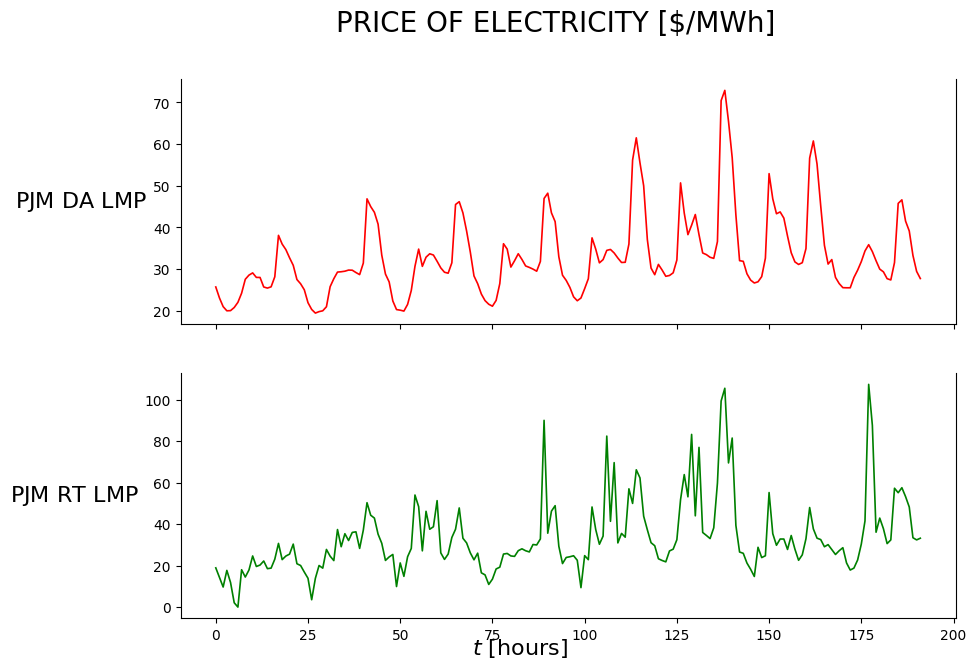

In [133]:
from certifi.core import where
def plot_data(df):
  n_charts = 2
  ylabelsize = 16
  fig, axs = plt.subplots(n_charts, sharex=True)
  fig.set_figwidth(10); fig.set_figheight(7)
  fig.suptitle('PRICE OF ELECTRICITY [$/MWh]', fontsize=20)
  i = 0
  axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(True)
  axs[i].plot(df['PJM_DA_LMP'], 'r')
  axs[i].set_ylabel('$\mathrm{PJM\ DA\ LMP}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  i = 1
  axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(True)
  axs[i].plot(df['PJM_RT_LMP'], 'g')
  axs[i].set_ylabel('$\mathrm{PJM\ RT\ LMP}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  axs[i].set_xlabel('$t\ \mathrm{[hours]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
plot_data(df_raw)  

## 3 DATA PREPARATION

The most important aspect of data preparation will be to create an empirical distribution rather than to try and fit the data to a parametric distribution. This involves the computation of a cumulative distribution from the data. We first sort the prices from smallest to largest. Let this ordered sequence be represented by $\tilde{p}_t$ where $\tilde{p}_{t-1} \le \tilde{p}_t$. Also, let $T$ be the number of time periods. The percentage of time periods with a price less than $\tilde{p}_t$ is then $t/T$. The empirical cumulative distribution is given by
$$
F_P(\tilde{p}_t) = \frac{t}{T}
$$


In [134]:
# hide
df_hist_price = pd.DataFrame({'hist_price': exogParams['hist_price']});
print(df_hist_price.shape)
# print(df_hist_price)
# df_hist_price.plot('hist_price');
# df_hist_price.plot();

(192, 1)


(191, 1)


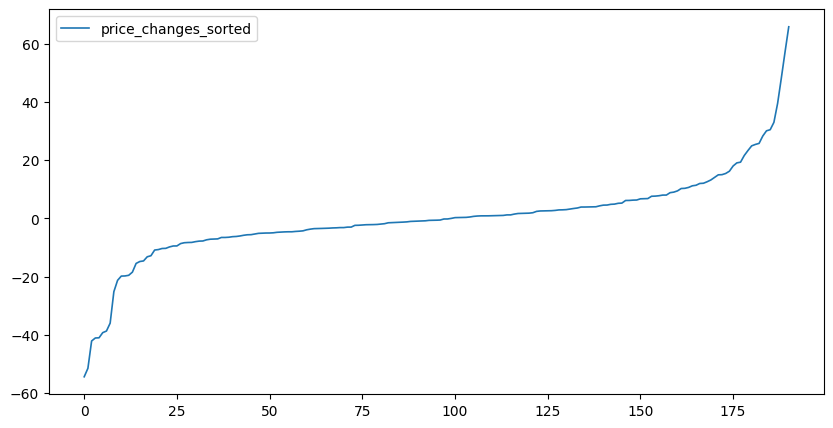

In [135]:
df_price_changes_sorted = pd.DataFrame({'price_changes_sorted': exogParams['price_changes_sorted']});
print(df_price_changes_sorted.shape)
# print(df_price_changes_sorted)
df_price_changes_sorted.plot(figsize=(10,5));

(50, 1)


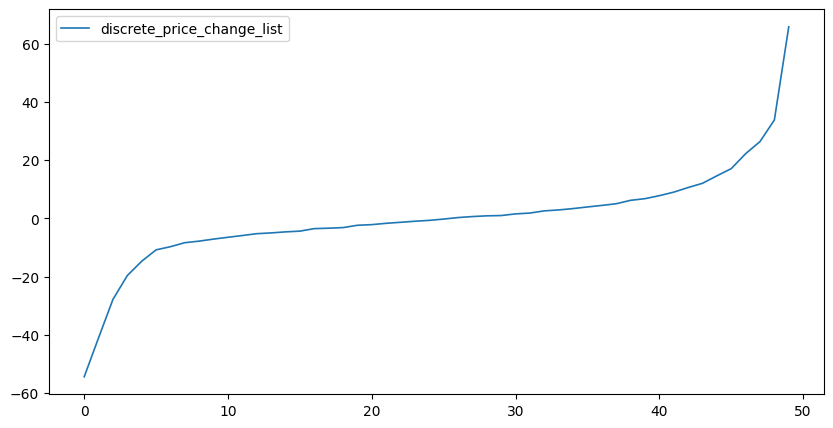

In [136]:
df_discrete_price_change_list = pd.DataFrame(
    {'discrete_price_change_list': exogParams['discrete_price_change_list']})
print(df_discrete_price_change_list.shape)
# print(df_discrete_price_change_list)
df_discrete_price_change_list.plot(figsize=(10,5));

(50, 1)


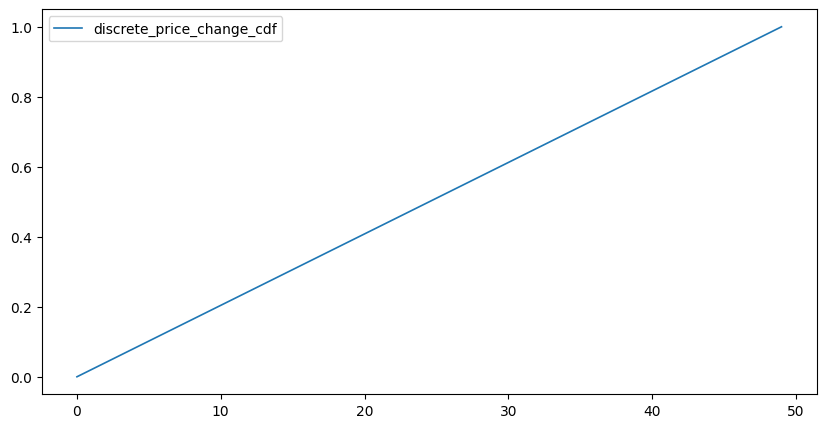

In [137]:
df_discrete_price_change_cdf = pd.DataFrame(
    {'discrete_price_change_cdf': exogParams['discrete_price_change_cdf']})
print(df_discrete_price_change_cdf.shape)
# print(df_discrete_price_change_cdf)
df_discrete_price_change_cdf.plot(figsize=(10,5));

## 4 MODELING

### 4.1 Narrative

There has been an interest making use of batteries to exploit electricity price spikes. Power is bought when the price is low and power is sold when the price is high. This is known as *battery arbitrage*.

This project hightlights some interesting aspects of this kind of problem. Among these are:

- Electricity prices on the grid can be very volatile (varies between about \$20/MWh to about \$1,000/MWh or even \$10,000/MWh for brief periods)
- Prices change every 5 minutes
- We assume that we can observe the price and then decide if we want to buy or sell
- We can only buy or sell for an entire 5-minute interval at a maximum rate of 0.01 MW
- Wind energy can be forecasted but not very well. Rolling forecasts can be used.
- Energy demand is variable but quite predictable. It depends on:
  - temperature (primarily)
  - humidity (less)
- Energy may be bought from or sold to the grid at current grid prices.
- There is a 5% to 10% loss when converting power from AC (grid) to DC (to store in battery).



### 4.2 Core Elements
This section attempts to answer three important questions:
- What metrics are we going to track?
- What decisions do we intend to make?
- What are the sources of uncertainty?

For this problem, the only metric we are interested in is the amount of profit we make after each decision window. A single type of decision needs to be made at the start of each window - how much energy to buy or sell. The only source of uncertainty is the price of energy.


### 4.3 Mathematical Model | SUM Design

A Python class is used to implement the model for the SUM (System Under Management):

```
class EnergyStorageModel():
        def __init__(
        self, SVarNames, xVarNames, S_0, params, exogParams, possibleDecisions,
        W_fn=None, S__M_fn=None, C_fn=None):
        ...
        ...
```

#### 4.3.1 State variables

The *state variables* represent *what we need to know*.

- $R_t$
  - amount of energy stored in the battery at time $t$
  - measured in kWh or MWh
- $p_t$
  - price of energy on the grid

The state is:

$S_t = (R_t,p_t)$

The state variables are represented by the following variables in the `EnergyStorageModel` class:

```
        self.SVarNames = SVarNames
        self.State = namedtuple('State', SVarNames) # 'class'
        self.S_t = self.build_state(self.S_0) # 'instance'
```
where
```
SVarNames = ['R_t', 'p_t']
```

#### 4.3.2 Decision variables

The *decision variables* represent *what we control*.

- $x_t$
  - amount of energy bought from ($x_t>0$) or sold to ($x_t<0$) the grid
- Losses
  - When energy is transferred to or from the battery a loss is incurred
  - Assume the loss into the battery is the same as the loss out of the battery
  - $\eta$ is the fraction of the energy retained
  - $1 - \eta$ is the loss
- Constraints
  - buy from grid $(x_t>0)$:
    - $x_t \le \frac{1}{\eta}(R^{max} - R_t)$
  - sell to grid $(x_t<0)$:
    - $-x_t \le R_t$, which comes to
    - $x_t \ge -R_t$
- Decisions are made with a policy (TBD below):
  - $X^{\pi}(S_t)$

The decision variables are represented by the following variables in the `EnergyStorageModel` class:
```
self.Decision = namedtuple('Decision', xVarNames) # 'class'
```
where
```
xVarNames = ['x_t_buy', 'x_t_hold', 'x_t_sell']
```
**NOTE: We use a 1-hot representation of the decision variable. For this reason, some of our method names will have a suffix '_1hot' to point this out. In followup notebooks we will move away from the 1-hot representation.**

#### 4.3.3 Exogenous information variables


The *exogenous information variables* represent *what we did not know (when we made a decision)*. These are the variables that we cannot control directly. The information in these variables become available *after* we make the decision $x_t$.

When we assume that the price in each time period is revealed, without any model to predict the price based on past prices, we have:

$$
W_{t+1} = p_{t+1}
$$

Alternatively, when we assume that we observe the change in price $\hat{p}=p_t-p_{t-1}$, we have:

$$
W_{t+1} = \hat{p}_{t+1}
$$

The exogenous information have been preprocessed and is captured in:

- `exogParams['hist_price']`
- `exogParams['price_changes_sorted']`
- `exogParams['discrete_price_change_list']`
- `exogParams['discrete_price_change_cdf']`

The latest exogenous information can be accesses by calling the following method from `class EnergyStorageModel()`:

```
def W_fn(self, t):
  W_tt1 = self.exogParams['hist_price'][t]
  return W_tt1
```

#### 4.3.4 Transition function

The *transition function* describe how the state variables evolve over time. Because we currently have two state variables in the state, $S_t=(R_t,p_t)$, we have the equations:

$$
\begin{aligned}
R_{t+1} &= R_t + \eta x_t \\
p_{t+1} &= p_t + \hat{p}_{t+1} 
\end{aligned}
$$

Collectively, they represent the general transition function:

$$
S_{t+1} = S^M(S_t,X^{\pi}(S_t))
$$

The transition function is implemented by the following method in `class EnergyStorageModel()`:

```
def S__M_fn_1hot(self, t, x_t): #.
    p_tt1 = self.W_fn(t)
    R_tt1 = self.S_t.R_t + (self.initArgs['eta']*x_t.x_t_buy) - x_t.x_t_sell
    if len(self.SVarNames) == 2:
        S_tt1 = self.build_state({'R_t': R_tt1, 'p_t': p_tt1})
    elif len(self.SVarNames) == 3:
        S_tt1 = self.build_state({'R_t': R_tt1, 'p_t': p_tt1, 'p_t_1': self.S_t.p_t})
    return S_tt1
```

#### 4.3.5 Objective function

The *objective function* captures the performance metrics of the solution to the problem. It is given by:

$$
\max_{\pi} \mathbb{E} \sum_{t=0}^T C(S_t,x_t)
$$

where
$$
C(S_t,x_t) = -p_tx_t
$$

The contribution (reward) function is implemented by the following method in class EnergyStorageModel():

```
def C_fn_1hot(self, x_t):
    C_t = self.S_t.p_t*( self.initArgs['eta']*x_t.x_t_sell - x_t.x_t_buy )#. C(S_t, x_t, W_t+1)
    return C_t
```

#### 4.3.6 Implementation of SUM Model

Here is the complete implementation of the `EnergyStorageModel` class:

In [138]:
class EnergyStorageModel():
    def __init__(
        self, SVarNames, xVarNames, S_0, params, exogParams, possibleDecisions,
        W_fn=None, S__M_fn=None, C_fn=None):
        self.initArgs = params
        self.prng = np.random.RandomState(params['seed'])
        self.exogParams = exogParams
        self.S_0 = S_0
        self.SVarNames = SVarNames
        self.xVarNames = xVarNames
        self.possibleDecisions = possibleDecisions
        self.State = namedtuple('State', SVarNames) # 'class'
        self.S_t = self.build_state(self.S_0) # 'instance'
        self.Decision = namedtuple('Decision', xVarNames) # 'class'
        self.cumC = 0.0 #. cumulative reward; use F or cumF for final (i.e. no cumulative) reward
        # self.states = [self.S_t] # keep a list of states visited

    def reset(self):
        self.cumC = 0.0
        self.S_t = self.build_state(self.S_0)
        # self.states = [self.S_t]

    def build_state(self, info):
        return self.State(*[info[sn] for sn in self.SVarNames])

    def build_decision_1hot(self, x_t_info, R_t):
        x_t_info_constrained = {'buy': 0, 'hold': 0, 'sell': 0} #.
        #amount of power that can be bought/sold is limited by constraints
        for xn in self.xVarNames:
            if xn == 'x_t_buy' and x_t_info[xn] > 0:
                x_t_info_constrained[xn] = (self.initArgs['R__max'] - R_t)/self.initArgs['eta']
            elif xn == 'x_t_sell' and x_t_info[xn] > R_t:
                x_t_info_constrained[xn] = R_t
            else: # 'x_t_hold'
                x_t_info_constrained[xn] = x_t_info[xn]
        return self.Decision(*[x_t_info_constrained[xn] for xn in self.xVarNames])

    def W_fn(self, t):
        W_tt1 = self.exogParams['hist_price'][t]
        return W_tt1

    def S__M_fn_1hot(self, t, x_t):
        p_tt1 = self.W_fn(t)
        R_tt1 = self.S_t.R_t + (self.initArgs['eta']*x_t.x_t_buy) - x_t.x_t_sell
        if len(self.SVarNames) == 2:
            S_tt1 = self.build_state({'R_t': R_tt1, 'p_t': p_tt1})
        elif len(self.SVarNames) == 3:
            S_tt1 = self.build_state({'R_t': R_tt1, 'p_t': p_tt1, 'p_t_1': self.S_t.p_t})
        return S_tt1

    def C_fn_1hot(self, x_t):
        C_t = self.S_t.p_t*( self.initArgs['eta']*x_t.x_t_sell - x_t.x_t_buy )# C(S_t, x_t, W_t+1)
        return C_t

    def step_1hot(self, t, x_t):
        self.cumC += self.C_fn_1hot(x_t)
        self.S_t = self.S__M_fn_1hot(t, x_t)
        return (self.S_t, self.cumC, x_t) #. for plotting

### 4.4 Uncertainty Model

As mentioned above in section 3, we make use of an empirical distribution rather than to try and fit the data to a parametric distribution. This involves the computation of a cumulative distribution from the data. We first sort the prices from smallest to largest. Let this ordered sequence be represented by $\tilde{p}_t$ where $\tilde{p}_{t-1} \le \tilde{p}_t$. Also, let $T$ be the number of time periods. The percentage of time periods with a price less than $\tilde{p}_t$ is then $t/T$. The empirical cumulative distribution is given by
$$
F_P(\tilde{p}_t) = \frac{t}{T}
$$

### 4.5 Policy Design
There are two main meta-classes of policy design. Each of these has two subclasses:
- Policy Search
  - Policy Function Approximations (PFAs)
  - Cost Function Approximations (CFAs)
- Lookahead
  - Value Function Approximations (VFAs)
  - Direct Lookaheads (DLAs)

In this project we will use the approach:
- A simple buy low, sell high parameterized policy (from the PFA class)

The buy low, sell high policy is implemented by the following method in class EnergyStoragePolicy():

```
def X__BuyLowSellHigh_1hot(self, t, S_t, theta): #. SDAM-9.4.1
    #. (SDAM-eq9.11): X^lohi(S_t|theta)
    theta__buy = theta[0] #. theta__buy
    theta__sell = theta[1] #. theta__sell
    if S_t.p_t <= theta__buy: #. -1(BUY) if p_t <= theta__buy
        x_t_info = self.model.possibleDecisions[0] #. BUY
    elif S_t.p_t >= theta__sell: #. +1(SELL) if p_t >= theta__sell
        x_t_info = self.model.possibleDecisions[1] #. SELL
    else: #. 0(HOLD) if theta__buy < p_t < theta__sell
        x_t_info = self.model.possibleDecisions[2] #. HOLD
    return x_t_info
```

#### 4.5.1 Implementation of Policy Design

The `EnergyStoragePolicy()` class implements the policy design.

In [139]:
import random
class EnergyStoragePolicy():
    def __init__(self, model, piNames):
        self.model = model
        self.piNames = piNames
        self.Policy = namedtuple('Policy', piNames)

    def X__BuyLowSellHigh_1hot(self, t, S_t, theta): #. SDAM-9.4.1
        #. (SDAM-eq9.11): X^lohi(S_t|theta)
        theta__buy = theta[0] #. theta__buy
        theta__sell = theta[1] #. theta__sell
        if S_t.p_t <= theta__buy: #. -1(BUY) if p_t <= theta__buy
            x_t_info = self.model.possibleDecisions[0] #. BUY
        elif S_t.p_t >= theta__sell: #. +1(SELL) if p_t >= theta__sell
            x_t_info = self.model.possibleDecisions[1] #. SELL
        else: #. 0(HOLD) if theta__buy < p_t < theta__sell
            x_t_info = self.model.possibleDecisions[2] #. HOLD
        return x_t_info

    def run_policy_1hot(self, piInfo, piName, params):
        model_copy = copy(self.model)
        T = params['T']
        # nTrades = {'buy': 0, 'sell': 0, 'hold': 0}
        # nTrades = {'x_t_buy': 0, 'x_t_sell': 0, 'x_t_hold': 0}
        buyList = []
        sellList = []
        for t in range(T):
            x_t_info = getattr(self, piName)(t, model_copy.S_t, piInfo)
            if t == model_copy.initArgs['T'] - 1: #Last time period - sell
                x_t_info = {'x_t_buy': 0, 'x_t_hold': 0, 'x_t_sell': 1}   
            x_t = model_copy.build_decision_1hot(x_t_info, model_copy.S_t.R_t)#.

            # nTrades['x_t_buy'] += x_t.x_t_buy; #print(f'### {x_t.buy=}')
            # nTrades['x_t_sell'] += x_t.x_t_sell; #print(f'### {x_t.sell=}')
            # nTrades['x_t_hold'] += model_copy.S_t.R_t
            if x_t.x_t_buy > 0:
                buyList.append((t, model_copy.S_t.R_t, model_copy.S_t.p_t, x_t.x_t_buy, params['R__max']))
            elif x_t.x_t_sell > 0:
                sellList.append((t, model_copy.S_t.R_t, model_copy.S_t.p_t, x_t.x_t_sell, params['R__max']))
            _, _, _ = model_copy.step_1hot(t, x_t) # step the model forward
        cumC = model_copy.cumC
        
        # print(f"Energy traded - Buy: {nTrades['x_t_buy']:.2f} - Hold: {nTrades['x_t_hold']:.2f} - Sell: {nTrades['x_t_sell']:.2f}")
        # print("Buy times and prices ")
        # for i in range(len(buyList)):
        #     print(f"t = {buyList[i][0]:.2f} and price = {buyList[i][1]:.2f}") #.
        # print("Sell times and prices ")
        # for i in range(len(sellList)):
        #     print(f"t = {sellList[i][0]:.2f} and price = {sellList[i][1]:.2f}") #.
        return cumC

    def run_policy_sample_paths_1hot(self, theta, piName, params):
        FhatIomega__lI = []
        for l in range(1, params['L'] + 1):
            model_copy = copy(self.model)
            record_l = [piName, theta, l]
            T = params['T']
            # nTrades = {'x_t_buy': 0, 'x_t_sell': 0, 'x_t_hold': 0}
            buyList = []
            sellList = []
            for t in range(T):
                x_t_info = getattr(self, piName)(t, model_copy.S_t, theta)
                if t == model_copy.initArgs['T'] - 1: #Last time period - sell
                    x_t_info = {'x_t_buy': 0, 'x_t_hold': 0, 'x_t_sell': 1}
                x_t = model_copy.build_decision_1hot(x_t_info, model_copy.S_t.R_t)
                # nTrades['x_t_buy'] += x_t.x_t_buy; #print(f'### {x_t.buy=}')
                # nTrades['x_t_sell'] += x_t.x_t_sell; #print(f'### {x_t.sell=}')
                # nTrades['x_t_hold'] += model_copy.S_t.R_t
                if x_t.x_t_buy > 0:
                    buyList.append((t, model_copy.S_t.R_t, model_copy.S_t.p_t, x_t.x_t_buy, params['R__max']))
                elif x_t.x_t_sell > 0:
                    sellList.append((t, model_copy.S_t.R_t, model_copy.S_t.p_t, x_t.x_t_sell, params['R__max']))
                _, _, _ = model_copy.step_1hot(t, x_t)
            FhatIomega__lI.append(model_copy.cumC) #. just above (SDAM-eq2.9) #. Fhat for this sample-path is in model_copy.cumC
            # print(f"Inventory traded - Buy: {nTrades['x_t_buy']:.2f} - Hold: {nTrades['x_t_hold']:.2f} - Sell: {nTrades['x_t_sell']:.2f}")
            # print("Buy times ")
            # for i in range(len(buy_list)):
            #     print(f"t={buy_list[i][0]}, R_t={buy_list[i][1]:.2f}, D_t={buy_list[i][2]:.2f}, x_t.x_t_buy={buy_list[i][3]:.2f}, R__max={buy_list[i][4]:.2f}")
            # print("Sell times ")
            # for i in range(len(sell_list)):
            #     print(f"t={sell_list[i][0]}, R_t={sell_list[i][1]:.2f}, D_t={sell_list[i][2]:.2f}, x_t.x_t_sell={sell_list[i][3]:.2f}, R__max={buy_list[i][4]:.2f}")
            # return cumC
        # end L
        return FhatIomega__lI

    def perform_grid_search_1hot(self, params, thetaValues):
        tS = time.time()
        cumCI_theta_I = {}
        bestTheta = None
        for theta in thetaValues:
            #print("Starting theta {}".format(theta))
            if theta[0] >= theta[1]:
                cumCI_theta_I[theta] = 0
            else:
                # print(f'\n=== {theta=} ===')
                cumC = self.run_policy_1hot(theta, "X__BuyLowSellHigh_1hot", params)
                cumCI_theta_I[theta] = cumC
                best_theta = max(cumCI_theta_I, key=cumCI_theta_I.get)
                # print(f"Finishing theta {theta} with cumC {cumC:.2f}. Best theta so far {best_theta}. Best contribution {cumCI_theta_I[best_theta]:.2f}")
        print(f"Finishing GridSearch in {time.time() - tS:.2f} secs")
        print(f"Best theta: {best_theta}. Best cumC {cumCI_theta_I[best_theta]:.2f}")
        return cumCI_theta_I

    def perform_grid_search_sample_paths_1hot(self, params, thetaValues):
        tS = time.time()
        Fhat_mean = None
        Fhat_var = None
        Fhat__meanI_th_I = {}
        Fhat__stdvI_th_I = {}
        Fhat_mean = None
        for theta in thetaValues:
            if theta[0] >= theta[1]:
                Fhat__meanI_th_I[theta] = 0
                # pass
            else:
                # print(f'\n=== {theta=} ===')
                FhatIomega__lI = self.run_policy_sample_paths_1hot(theta, "X__BuyLowSellHigh_1hot", params)
                Fhat_mean = np.array(FhatIomega__lI).mean() #. (SDAM-eq2.9); call Fbar in future
                Fhat_var = np.sum(np.square(np.array(FhatIomega__lI) - Fhat_mean))/(params['L'] - 1)
                Fhat__meanI_th_I[theta] = Fhat_mean
                Fhat__stdvI_th_I[theta]= np.sqrt(Fhat_var/params['L'])
                best_theta = max(Fhat__meanI_th_I, key=Fhat__meanI_th_I.get)
                # print(f"Finishing theta {theta} with cumC {Fhat__meanI_th_I[best_theta]:.2f}. Best theta so far {best_theta}. Best cumC {Fhat__meanI_th_I[best_theta]:.2f}")
        print(f"Finishing GridSearch in {time.time() - tS:.2f} secs")
        print(f"Best theta: {best_theta}. Best cumC {Fhat__meanI_th_I[best_theta]:.2f}")
        return Fhat__meanI_th_I, Fhat__stdvI_th_I

    def grid_search_theta_values(self, params):
        """
        this function gives a list of theta values needed to run a full grid search
        """
        theta_buy_values = np.arange(params['theta_buy_min'], params['theta_buy_max'], params['theta_inc'])
        theta_sell_values = np.arange(params['theta_sell_min'], params['theta_sell_max'], params['theta_inc'])

        theta_values = [(x, y) for x in theta_buy_values for y in theta_sell_values]        
        return theta_values, theta_buy_values, theta_sell_values

    def plot_heat_map(self, contribution_dict, theta_buy_values, theta_sell_values):
        contribution_values = [contribution_dict[(theta_buy,theta_sell)]  for theta_sell in theta_sell_values for theta_buy in theta_buy_values]
        contributions = np.array(contribution_values)
        increment_count = len(theta_buy_values)
        contributions = np.reshape(contributions, (-1, increment_count))

        fig, ax = plt.subplots()
        im = ax.imshow(contributions, cmap='hot',origin='lower',aspect='auto')
        # create colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
        # we want to show all ticks...
        ax.set_xticks(np.arange(0,len(theta_buy_values),5))
        ax.set_yticks(np.arange(0,len(theta_sell_values),5))
        # ... and label them with the respective list entries
        ax.set_xticklabels(theta_buy_values[::5])
        ax.set_yticklabels(theta_sell_values[::5])
        # rotate the tick labels and set their alignment.
        #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        ax.set_title("Heatmap of contribution values across different values of theta")

        ax.set_ylabel('Theta sell high values') 
        ax.set_xlabel('Theta buy low values')

        #fig.tight_layout()
        plt.show()
        return True

### 4.6 Evaluating Policies

#### 4.6.1 Training/Tuning

In [140]:
# UPDATE PARAMETERS
params.update({'Algorithm': 'GridSearch'}); pprint(f'{params=}')
params.update({'R__max': 1})
params.update({'R_0': 0})
params.update({'L': 500}) #add sample-paths
params.update({'T': 100}) #optimal theta not consistent, so raise T
params

("params={'Algorithm': 'GridSearch', 'T': 192, 'eta': 0.9, 'R__max': 1, 'R_0': "
 "1, 'seed': 189654913, 'theta_sell_min': 10, 'theta_sell_max': 100, "
 "'theta_buy_min': 10, 'theta_buy_max': 100, 'theta_inc': 1, "
 "'nPriceChangeInc': 50, 'priceDiscSet': '1, 0.5', 'run3D': False, "
 "'price_disc_list': [1.0, 0.5]}")


{'Algorithm': 'GridSearch',
 'T': 100,
 'eta': 0.9,
 'R__max': 1,
 'R_0': 0,
 'seed': 189654913,
 'theta_sell_min': 10,
 'theta_sell_max': 100,
 'theta_buy_min': 10,
 'theta_buy_max': 100,
 'theta_inc': 1,
 'nPriceChangeInc': 50,
 'priceDiscSet': '1, 0.5',
 'run3D': False,
 'price_disc_list': [1.0, 0.5],
 'L': 500}

In [141]:
# create a model and a policy
piNames = ['X__BuyLowSellHigh_1hot']
SVarNames = ['R_t', 'p_t']
initialState = {
    'R_t': params['R_0'],
    'p_t': exogParams['hist_price'][0],
}
xVarNames = ['x_t_buy', 'x_t_hold', 'x_t_sell']
possibleDecisions = [
    {'x_t_buy': 1, 'x_t_hold': 0, 'x_t_sell': 0}, 
    {'x_t_buy': 0, 'x_t_hold': 0, 'x_t_sell': 1},
    {'x_t_buy': 0, 'x_t_hold': 1, 'x_t_sell': 0}]
M = EnergyStorageModel(
    SVarNames, 
    xVarNames, 
    initialState, 
    params, 
    exogParams,
    possibleDecisions
)
P = EnergyStoragePolicy(M, piNames)

Finishing GridSearch in 3.77 secs
Best theta: (11, 38). Best cumC 141.01


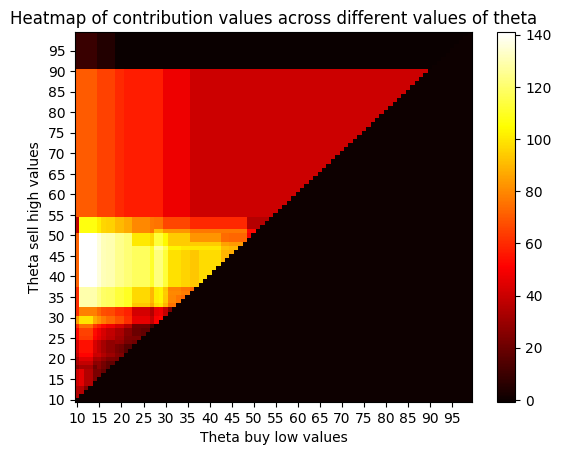

CPU times: user 4.17 s, sys: 142 ms, total: 4.31 s
Wall time: 4.19 s


In [142]:
%%time
##########################################################################
#GridSearch #. SDAM-9.4.1
if params['Algorithm'] == 'GridSearch':
    # obtain the theta values to carry out a full grid search
    grid_search_theta_values = P.grid_search_theta_values(params)
    # print(grid_search_theta_values)
    
    # use those theta values to calculate corresponding contribution values

    cumCI_theta_I = \
      P.perform_grid_search_1hot(params, grid_search_theta_values[0])
    P.plot_heat_map(
        cumCI_theta_I, 
        grid_search_theta_values[1], 
        grid_search_theta_values[2])
# 
# 
# OR
# 
# 
    # Fhat__meanI_th_I, Fhat__stdvI_th_I = \
    #   P.perform_grid_search_sample_paths_1hot(params, grid_search_theta_values[0])
    # P.plot_heat_map(
    #     Fhat__meanI_th_I, 
    #     grid_search_theta_values[1], 
    #     grid_search_theta_values[2])
##################################################################################

#### 4.6.2 Evaluation

In [143]:
params['R_0']

0

In [144]:
# create a model and a policy
piNames = ['X__BuyLowSellHigh_1hot']
SNames = ['R_t', 'p_t']
initialState = {
    # 'R_t': params['R_0'],
    'R_t': 1,
    'p_t': exogParams['hist_price'][0],
}
xVarNames = ['x_t_buy', 'x_t_hold', 'x_t_sell']
possibleDecisions = M.possibleDecisions
M_evalu = EnergyStorageModel(
    SVarNames, 
    xVarNames, 
    initialState, 
    params, 
    exogParams,
    possibleDecisions
)
P_evalu = EnergyStoragePolicy(M_evalu, piNames)
params

{'Algorithm': 'GridSearch',
 'T': 100,
 'eta': 0.9,
 'R__max': 1,
 'R_0': 0,
 'seed': 189654913,
 'theta_sell_min': 10,
 'theta_sell_max': 100,
 'theta_buy_min': 10,
 'theta_buy_max': 100,
 'theta_inc': 1,
 'nPriceChangeInc': 50,
 'priceDiscSet': '1, 0.5',
 'run3D': False,
 'price_disc_list': [1.0, 0.5],
 'L': 500}

In [145]:
def run_policy_evalu_1hot(piInfo_evalu, piName_evalu, stop_time_evalu):
    model_copy = copy(M_evalu)
    nTrades = {'x_t_buy': 0, 'x_t_sell': 0, 'x_t_hold': 0}
    buyList = []
    sellList = []
    record = []
    for t in range(stop_time_evalu):
        x_t_info = getattr(P_evalu, piName_evalu)(t, model_copy.S_t, piInfo_evalu)
        if t == stop_time_evalu - 1: #Last time period - sell
            x_t_info = {'x_t_buy': 0, 'x_t_hold': 0, 'x_t_sell': 1}   
        x_t = model_copy.build_decision_1hot(x_t_info, model_copy.S_t.R_t)
        # nTrades['x_t_buy'] += x_t.x_t_buy; #print(f'### {x_t.buy=}')
        # nTrades['x_t_sell'] += x_t.x_t_sell; #print(f'### {x_t.sell=}')
        # nTrades['x_t_hold'] += model_copy.S_t.R_t#.
        if x_t.x_t_buy > 0:
            buyList.append((t, model_copy.S_t.p_t))
        elif x_t.x_t_sell > 0:
            sellList.append((t, model_copy.S_t.p_t))
        res = model_copy.step_1hot(t, x_t) # step the model forward one iteration
        record.append([res[0].R_t, res[0].p_t, res[1], res[2].x_t_buy, res[2].x_t_hold, res[2].x_t_sell])
    cumC = model_copy.cumC
    # print("Energy traded - Sell: {:.2f} - Buy: {:.2f} - Hold % : {:.2f}".format(nTrades['sell'], nTrades['buy'], nTrades['hold']/model_copy.init_args['T']))
    # print(f"Energy traded - Sell: {nTrades['x_t_sell']:.2f} - Buy: {nTrades['x_t_buy']:.2f} - Hold % : {nTrades['x_t_hold']/model_copy.init_args['T']:.2f}") #.
    # print("Sell times and prices ")
    # for i in range(len(sell_list)):
    #     print(f"t = {sell_list[i][0]} and price = {sell_list[i][1]:.2f}") #.
    # print("Buy times and prices ")
    # for i in range(len(buy_list)):
    #     print(f"t = {buy_list[i][0]} and price = {buy_list[i][1]:.2f}") #.
    return cumC, record

In [146]:
# EVALUATION
piName_evalu = 'X__BuyLowSellHigh_1hot'
stop_time_evalu = 180

##### 4.6.2.1 Optimal policy

In [147]:
piName_evalu

'X__BuyLowSellHigh_1hot'

In [148]:
theta_evalu = (11, 38)
cumC, record = run_policy_evalu_1hot(theta_evalu, piName_evalu, stop_time_evalu)
labels = ["R_t", "p_t", "cumC", "x_t_buy", "x_t_hold", "x_t_sell"]
print(f'{theta_evalu=}')
df = pd.DataFrame.from_records(data=record, columns=labels); df[:20]

theta_evalu=(11, 38)


,R_t,p_t,cumC,x_t_buy,x_t_hold,x_t_sell
0,1.0000,18.9100,0.0000,0.0000,1,0.0000
1,1.0000,14.2700,0.0000,0.0000,1,0.0000
2,1.0000,9.6700,0.0000,0.0000,1,0.0000
3,1.0000,17.6800,0.0000,0.0000,0,0.0000
4,1.0000,11.8800,0.0000,0.0000,1,0.0000
5,1.0000,2.0800,0.0000,0.0000,1,0.0000
6,1.0000,0.0000,0.0000,0.0000,0,0.0000
7,1.0000,18.0000,0.0000,0.0000,0,0.0000
8,1.0000,14.4800,0.0000,0.0000,1,0.0000
9,1.0000,17.8800,0.0000,0.0000,1,0.0000


In [149]:
df.tail()

,R_t,p_t,cumC,x_t_buy,x_t_hold,x_t_sell
175,0.0000,30.3400,184.7686,0.0000,1,0.0000
176,0.0000,41.5300,184.7686,0.0000,1,0.0000
177,0.0000,107.3400,184.7686,0.0000,0,0.0000
178,0.0000,87.5700,184.7686,0.0000,0,0.0000
179,0.0000,36.0800,184.7686,0.0000,0,0.0000


##### 4.6.2.2 Non-optimal policy

In [150]:
theta_evalu_non=(30, 95)
cumC, record = run_policy_evalu_1hot(theta_evalu_non, piName_evalu, stop_time_evalu)
labels = ["R_t", "p_t", "cumC", "x_t_buy", "x_t_hold", "x_t_sell"]
print(f'{theta_evalu_non=}')
df_non = pd.DataFrame.from_records(data=record, columns=labels); df[:20]

theta_evalu_non=(30, 95)


,R_t,p_t,cumC,x_t_buy,x_t_hold,x_t_sell
0,1.0000,18.9100,0.0000,0.0000,1,0.0000
1,1.0000,14.2700,0.0000,0.0000,1,0.0000
2,1.0000,9.6700,0.0000,0.0000,1,0.0000
3,1.0000,17.6800,0.0000,0.0000,0,0.0000
4,1.0000,11.8800,0.0000,0.0000,1,0.0000
5,1.0000,2.0800,0.0000,0.0000,1,0.0000
6,1.0000,0.0000,0.0000,0.0000,0,0.0000
7,1.0000,18.0000,0.0000,0.0000,0,0.0000
8,1.0000,14.4800,0.0000,0.0000,1,0.0000
9,1.0000,17.8800,0.0000,0.0000,1,0.0000


##### 4.6.2.3 Visualization

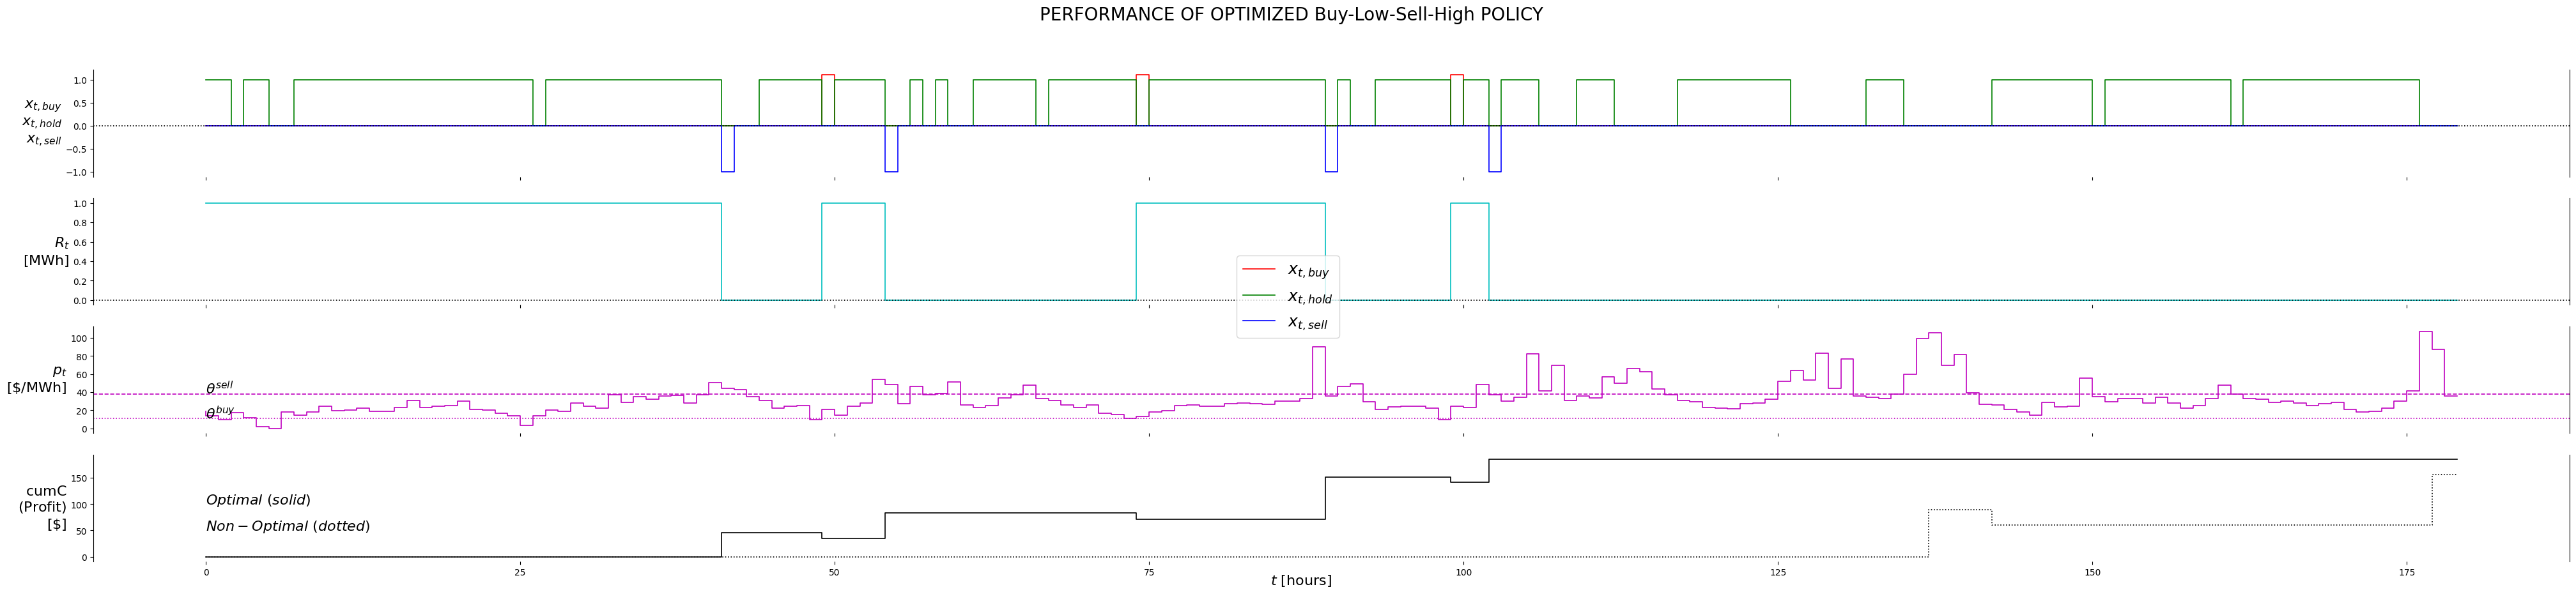

In [151]:
from certifi.core import where
def plot_output_1hot(df1, df2):
  legendlabels =     [r'$x_{t,buy}$', r'$x_{t,hold}$', r'$x_{t,sell}$']
  n_charts = 4
  ylabelsize = 16
  mpl.rcParams['lines.linewidth'] = 1.2
  fig, axs = plt.subplots(n_charts, sharex=True)
  fig.set_figwidth(50); fig.set_figheight(10)
  fig.suptitle('PERFORMANCE OF OPTIMIZED Buy-Low-Sell-High POLICY', fontsize=20)
  i = 0 #buy/hold/sell
  axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
  axs[i].step(df1['x_t_buy'], 'r')
  axs[i].step(df1['x_t_hold'], 'g')
  axs[i].step(-df1['x_t_sell'], 'b')
  axs[i].axhline(y=0, color='k', linestyle=':')  
  axs[i].set_ylabel('$x_{t,buy}$\n$x_{t,hold}$\n$x_{t,sell}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  i = 1 #R_t
  axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
  axs[i].step(df1['R_t'], 'c')
  axs[i].axhline(y=0, color='k', linestyle=':')
  axs[i].set_ylabel('$R_t$'+'\n'+'$\mathrm{[MWh]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  i = 2 #p_t
  axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
  axs[i].step(df1['p_t'], 'm')
  axs[i].axhline(y=theta_evalu[0], color='m', linestyle=':')
  axs[i].text(0, theta_evalu[0], r'$\theta^{buy}$', size=16)
  axs[i].axhline(y=theta_evalu[1], color='m', linestyle='--')
  axs[i].text(0, theta_evalu[1], r'$\theta^{sell}$', size=16)
  axs[i].set_ylabel('$p_t$'+'\n'+'$\mathrm{[\$/MWh]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  i = 3 #cumC
  axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
  axs[i].step(df1['cumC'], 'k')
  axs[i].step(df2['cumC'], 'k:')
  axs[i].text(0, 100, r'$Optimal\ (solid)$', size=16)
  axs[i].text(0, 50, r'$Non-Optimal\ (dotted)$', size=16)
  axs[i].set_ylabel('$\mathrm{cumC}$'+'\n'+'$\mathrm{(Profit)}$'+'\n'+''+'$\mathrm{[\$]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  axs[i].set_xlabel('$t\ \mathrm{[hours]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
  fig.legend(labels=legendlabels, loc='center', fontsize=18)
plot_output_1hot(df, df_non)  